In [85]:
import torch
import torch.nn.functional as F
from torch.nn.functional import relu, binary_cross_entropy_with_logits, sigmoid
from torchvision import models
from torch import nn
from skimage import io
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import cv2

In [83]:
def round_tensor(tensor):
    return torch.round(tensor)
def scale_tensor(tensor):
    tensor_min = torch.min(tensor)
    tensor_max = torch.max(tensor)
    return (tensor - tensor_min) / (tensor_max - tensor_min)
def compare_tensors(t1, t2):
    return (t1 > t2).float()

In [72]:
import matplotlib.pyplot as plt

def plot_image(array):
    plt.imshow(array, cmap='gray')
    plt.show()
    
def plot_histogram(tensor):
    plt.hist(tensor.numpy().flatten(), bins='auto')
    plt.show()

In [63]:
class MyDataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Arguments:
            root_dir (string): path to folder containing images and masks
        """
        self.root_dir = root_dir
        self.frames = []
        self.masks = []
        for directory in os.listdir(root_dir):
            for file in os.listdir(root_dir + '/' + directory):
                if file.endswith('mask.png'):
                    img = io.imread(root_dir + '/' + directory + '/' + file)
                    self.masks.append(img)
                else:
                    img = io.imread(root_dir + '/' + directory + '/' + file)
                    self.frames.append(img)
        assert len(self.frames) == len(self.masks)
        self.transform = transform
        print('Loaded ' + str(len(self.frames)) + ' images and masks')

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        frame = self.frames[idx]
        mask = self.masks[idx]
        tens_pos = round_tensor(self.transform(mask))
        tens_neg = 1-tens_pos
        

        if self.transform:
            frame = self.transform(frame)
            #mask = torch.cat((tens_pos, tens_neg), dim=0)
            mask = self.transform(mask)
        return frame, mask

In [86]:
def _assert_no_grad(tensor):
    assert not tensor.requires_grad, \
        "nn criterions don't compute the gradient w.r.t. targets - please " \
        "mark these tensors as not requiring gradients"

class CrossEntropy2D(nn.Module):
    def __init__(self, ignore_index, reduction='mean', weight=None):
        """Initialize the module

        Args:
            ignore_index: specify which the label index to ignore.
            reduction (str): reduction method. See torch.nn.functional.cross_entropy for details.
            output_dir (str): output directory to save the checkpoint
            weight: weight for samples. See torch.nn.functional.cross_entropy for details.
        """
        super(CrossEntropy2D, self).__init__()
        self.weight = weight
        self.ignore_index = ignore_index
        self.reduction = reduction

    def forward(self, output, target, resize_scores=True):
        """Forward pass of the loss function

        Args:
            output (torch.nn.Tensor): output logits, i.e. network predictions w.o. softmax activation.
            target (torch.nn.Tensor): ground truth labels.
            resize_scores (bool): if set to True, when target and output have different widths or heights,
                                  upsample output bilinearly to match target resolution. Otherwise, downsample
                                  target using nearest neighbor to match input.
        Returns:
            loss (torch.nn.Tensor): loss between output and target.
        """
        _assert_no_grad(target)

        b, c, h, w = output.size()
        tb, tc ,th, tw = target.size()

        assert(b == tb)

        # Handle inconsistent size between input and target
        if resize_scores:
            if h != th or w != tw:  # upsample logits
                output = nn.functional.interpolate(output, size=(th, tw), mode="bilinear", align_corners=False)
        else:
            if h != th or w != tw:  # downsample labels
                target = nn.functional.interpolate(target.view(b, 1, th, tw).float(), size=(h, w), mode="nearest").view(b, h, w).long()


        loss = nn.functional.cross_entropy(
            output, target, weight=self.weight, reduction=self.reduction
        )

        return loss
    
def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = binary_cross_entropy_with_logits(pred, target)

    pred = sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()

def dice_loss_2(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()
    
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss_2(input, target))
        return loss.mean()

In [54]:
from torch.utils.data import random_split

def train_test_split(dataset, test_size=0.2):
    """
    Splits a PyTorch Dataset into training and testing datasets.

    Args:
        dataset (torch.utils.data.Dataset): The dataset to split.
        test_size (float, optional): The proportion of the dataset to include in the test split. Defaults to 0.2.

    Returns:
        tuple: A tuple containing the training Dataset and the testing Dataset.
    """
    # Calculate the number of samples to include in the test split
    test_length = round(test_size * len(dataset))
    train_length = len(dataset) - test_length

    # Use PyTorch's random_split function to split the dataset
    train_dataset, test_dataset = random_split(dataset, [train_length, test_length])

    return train_dataset, test_dataset

def write_tensor_to_file(tensor, filename):
    np.savetxt(filename, tensor.numpy())

In [55]:
class UNet2(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        # In the decoder, transpose convolutional layers with the ConvTranspose2d function are used to upsample the feature maps to the original size of the input image. 
        # Each block in the decoder consists of an upsampling layer, a concatenation with the corresponding encoder feature map, and two convolutional layers.
        # -------
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)
        xe41 = relu(self.e41(xp3))

        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [64]:
scaled_size = 224
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((scaled_size, scaled_size)),
        transforms.ToTensor(),
    ])
d = MyDataset('C:/Users/lucas/Documents/HS23/AML/task3/data', transform=transform)
train_dataset, test_dataset = train_test_split(d, test_size=0.2)
train_loader = DataLoader(
    train_dataset,
    batch_size=24,
    shuffle=True,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    pin_memory=True
)

Loaded 195 images and masks


In [87]:
model = UNet2(1)
criterion = MixedLoss(10.0,2.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device:', device)
losses = []
model.to(device)
model.train()
for epoch in range(1):
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        #print('output shape:', output.shape,'input shape:', data.shape)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        print('Epoch:', epoch, 'Batch:', batch_idx, 'Loss:', loss.item())
    print(losses)
        

device: cpu
Epoch: 0 Batch: 0 Loss: 2.4559316635131836
Epoch: 0 Batch: 1 Loss: 2.294203519821167
Epoch: 0 Batch: 2 Loss: 2.0563106536865234
Epoch: 0 Batch: 3 Loss: 1.281853199005127
Epoch: 0 Batch: 4 Loss: 25.9282283782959
Epoch: 0 Batch: 5 Loss: 0.7928029298782349
Epoch: 0 Batch: 6 Loss: 1.3603341579437256
[2.4559316635131836, 2.294203519821167, 2.0563106536865234, 1.281853199005127, 25.9282283782959, 0.7928029298782349, 1.3603341579437256]


Test Loss: 0.5729807615280151
output shape: torch.Size([1, 2, 224, 224])
-0.6343198 -0.0903952


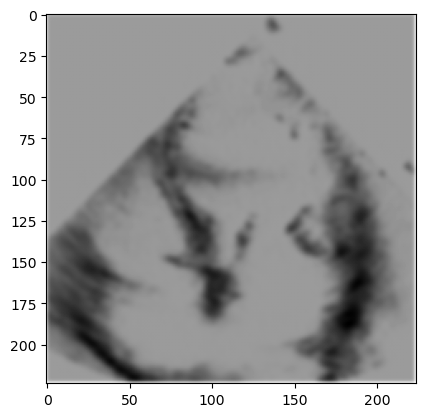

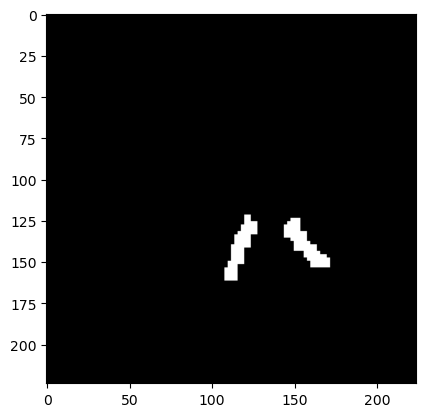

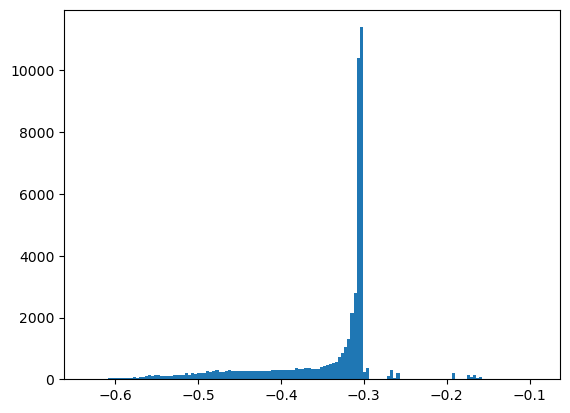

In [90]:
model.eval()
first = True
for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        loss = calc_loss(output, target, None)
        print('Test Loss:', loss.item())
        if batch_idx == 0:
                scaled_pos = scale_tensor(output.detach()[0,0,:,:])
                scaled_neg = scale_tensor(output.detach()[0,1,:,:])
                comp = compare_tensors(scaled_pos, scaled_neg)
                print('output shape:', output.shape)
                target_array = target.detach()[0,0,:,:].numpy()
                output_array = output.detach()[0,0,:,:].numpy()
                data_array = data.detach()[0,0,:,:].numpy()
                print(np.min(output_array), np.max(output_array))
                plot_image(output_array)
                plot_image(target_array)
                plot_histogram(output.detach()[0,0,:,:])
                first = False
                break
        
        

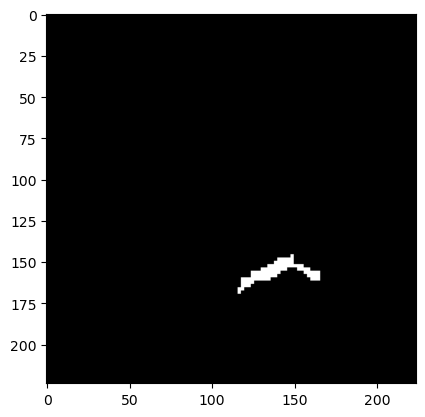

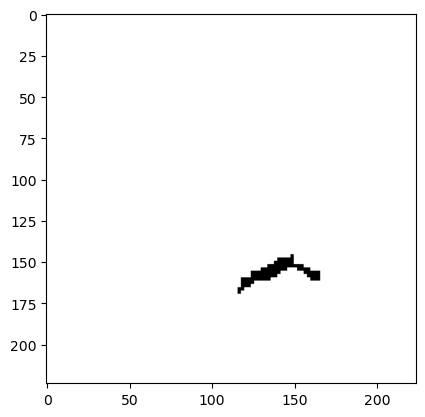

In [65]:
datapoint = train_dataset[0]
datapoint[1].shape
plot_image(datapoint[1].numpy()[0,:,:])
plot_image(datapoint[1].numpy()[1,:,:])